# Seminar 5



Generating Short Texts Using Transformer

Texts can be generated using Transformer by predicting the next sequence symbol based on previous ones. We will use the Transformer architecture.


In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

The 'names' file contains ~8k names in Latin script.

The model will receive a name like 'Amandy' as input and output the same name with a shift: 'mandy '.

To help the network learn to generate capital letters, we'll add a special token '_' at the beginning.

We also need a rule for stopping generation (this could be simply limiting the number of steps). Alternatively, we can add a special <EOS> token at the end of each training example. In this case, we'll denote it as '#':


```
_Amandy --> Amandy#
```

We can stop generation when <EOS> appears early.

For generation, at each step we'll input the letter predicted in the previous step.

In [ ]:
import os
start_token = "_"
eos = '#'

with open("names.txt") as f:
    names = f.readlines()
    #Your code here
    names = [start_token + name.replace('\n', eos) for name in names]

names = list(set(names))  # there are repetitions in the dataset
print('There are {} names: '.format(len(names)))
for x in names[::1000]:
    print(x)

There are 7579 names: 
_Alanna#
_Laural#
_Evette#
_Teodora#
_Gusty#
_Niki#
_Verna#
_Eliot#


How often evey letter occurs:

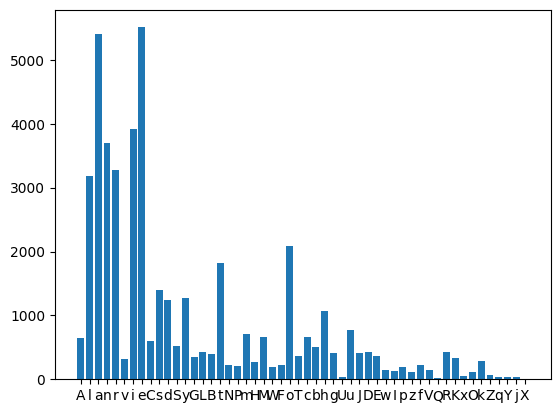

In [ ]:
letters = []
for name in names:
    letters.extend(list(name))

from collections import Counter
counts = Counter(letters)
new_counts = {}
for key in counts.keys():
    if key.isalpha():
        new_counts[key] = counts[key]


plt.bar(range(len(new_counts)), list(new_counts.values()))
plt.xticks(range(len(new_counts)), list(new_counts.keys()))

plt.show()

In the lowercase:

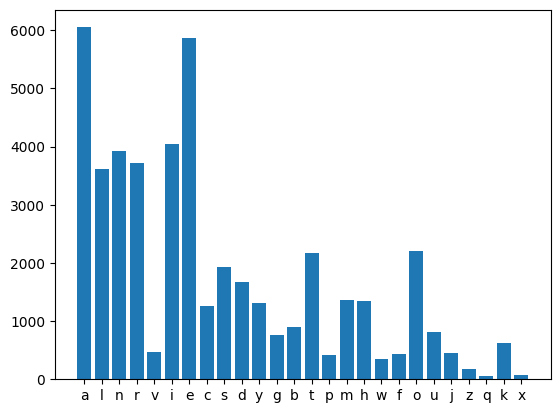

In [ ]:
letters = []
for name in names:
    letters.extend(list(map(lambda x: x.lower(), list(name))))

from collections import Counter
counts = Counter(letters)
new_counts = {}
for key in counts.keys():
    if key.isalpha():
        new_counts[key] = counts[key]


plt.bar(range(len(new_counts)), list(new_counts.values()))
plt.xticks(range(len(new_counts)), list(new_counts.keys()))

plt.show()

The length of the names:

max length = 17


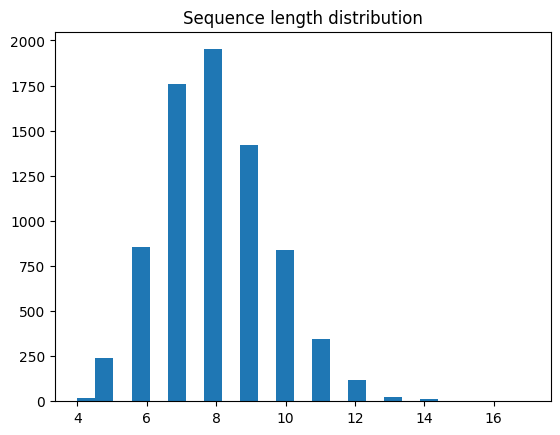

In [ ]:
MAX_LENGTH = max(map(len, names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len,names)), bins=25);

In [ ]:
names[:10]

['_Alanna#',
 '_Arvie#',
 '_Casandra#',
 '_Sayers#',
 '_Gladis#',
 '_Lilly#',
 '_Bendite#',
 '_Nidia#',
 '_Stanley#',
 '_Pammie#']

Let's create a vocabulary. Each token will be assigned a number (token index) - these numbers will be fed into the model.

Let's fill two dictionaries for converting tokens <-> indices.

We want the token ("_") (also known as start_token) to have number 0 in the dictionary.

In [ ]:
tokens = list(Counter([item for sublist in names for item in sublist]).keys())
tokens[:10]

['_', 'A', 'l', 'a', 'n', '#', 'r', 'v', 'i', 'e']

In [ ]:
tok2id =  {token:i for i, token in enumerate(tokens)} #Your code here
id2tok =  {i:token for i, token in enumerate(tokens)}#Your code here

n_tokens = len(tokens)
print ('There are', n_tokens, 'tokens')

assert 50 < n_tokens < 60

print('Vocabular: ' + "".join(tokens))

There are 57 tokens
Vocabular: _Alan#rvieCsdSyGLBtNPmHMWFoTcbhgUuJDEwIpzfVQRKxO-kZqYj X'


In [ ]:
tok2id['_'], id2tok[0]

(0, '_')

In [ ]:
tok2id['G'], id2tok[15]

(15, 'G')

In [ ]:
tok2id['#']

5

In [ ]:
tok2id[' ']

54

Function to create batch



In [ ]:
def to_matrix(names, max_len=None, pad=tok2id[' '], dtype=np.int64):
    """Casts a list of names into matrix"""

    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(tok2id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [ ]:
print('\n'.join(names[:10]))
print(to_matrix(names[:10]))

_Alanna#
_Arvie#
_Casandra#
_Sayers#
_Gladis#
_Lilly#
_Bendite#
_Nidia#
_Stanley#
_Pammie#
[[ 0  1  2  3  4  4  3  5 54 54]
 [ 0  1  6  7  8  9  5 54 54 54]
 [ 0 10  3 11  3  4 12  6  3  5]
 [ 0 13  3 14  9  6 11  5 54 54]
 [ 0 15  2  3 12  8 11  5 54 54]
 [ 0 16  8  2  2 14  5 54 54 54]
 [ 0 17  9  4 12  8 18  9  5 54]
 [ 0 19  8 12  8  3  5 54 54 54]
 [ 0 13 18  3  4  2  9 14  5 54]
 [ 0 20  3 21 21  8  9  5 54 54]]


In [ ]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(names, test_size=0.2, random_state=42)

len(train_data), len(val_data)

(6063, 1516)

In [ ]:
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
from IPython.display import clear_output

# Char-Transformer for names

Let's write a neural network that:

* Encodes input symbols and their positions using Embeddings tables

* Passes tensors through `TransformerEncoder`

* Gets logits for predictions

Transformer can process the entire sequence in one pass. To prevent the model from "looking into the future", i.e., using information about upcoming symbols, we need to generate a mask. `TransformerEncoder` should take a sequence of symbols and a mask as input.




![Transformer](https://drive.google.com/uc?export=view&id=1gXILzT3mGgc0mGlvqY-6R4bGs3Lx2YxM)
Source of the picture: [illustrated transformer](http://jalammar.github.io/illustrated-transformer/)

In [ ]:
class NameTransformer(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, n_layers=2, n_head=2, dropout=0.1):
        super(NameTransformer, self).__init__()
        self.vocab_size = vocab_size

        self.emb_size = emb_size
        self.emb = nn.Embedding(vocab_size, emb_size) #your code here
        self.trans = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=emb_size,
                                                                      nhead=n_head,
                                                                      dim_feedforward=hidden_size,
                                                                      dropout=dropout),
                                           num_layers=n_layers)#your code here
        self.fc = nn.Linear(emb_size, vocab_size)#your code here

    def _generate_square_subsequent_mask(self, seq_len):
        # Need mask of size seq_len x seq_len
        # if while coding symbol i j is availible,
        # (i,j) is  0, otherwise -inf

        #We need upper triangle matrix with -inf over diagonal
        return torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), 1) #your code here

    def forward(self, input):

        emb = self.emb(input) * np.sqrt(self.emb_size)
        mask = self._generate_square_subsequent_mask(len(input))

        output = self.fc(self.trans(emb, mask))

        return output

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])

# Code for training

In [ ]:
bs = 32
total_steps = 0
train_batches = np.array_split(train_data, len(train_data) // bs)
for batch in train_batches:
    nums = to_matrix(batch)
    print(nums.shape)
    break

(33, 12)


In [ ]:
def train_epoch(model, optimizer, train_batches):
    loss_log = []
    model.train()

    for batch in train_batches:
        nums = to_matrix(batch)


        #How to get input and output?
        #We do not have a separate target?

        #Word without last symbol
        data = torch.tensor(nums[:, :-1]) #Your code here
        #Word without first symbol
        target = torch.tensor(nums[:, 1:]).flatten() #Your code here


        optimizer.zero_grad()
        output = model(data).reshape(-1, model.vocab_size)


        loss = nn.CrossEntropyLoss()(output, target)

        loss.backward()
        optimizer.step()

        loss = loss.item()
        loss_log.append(loss)
    return loss_log

def test(model, test_batches):
    loss_log = []
    model.eval()
    for batch in test_batches:
        nums = to_matrix(batch)

        #Word without last symbol
        data = torch.tensor(nums[:, :-1]) #Your code here
        #Word without first symbol
        target = torch.tensor(nums[:, 1:]).flatten() #Your code here


        output = model(data).reshape(-1, model.vocab_size)
        loss = nn.CrossEntropyLoss()(output, target)

        loss = loss.item()
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

def train(model, opt, n_epochs):
    train_log = []
    val_log = []

    bs = 32
    total_steps = 0
    train_batches = np.array_split(train_data, len(train_data) // bs)
    test_batches = np.array_split(val_data, len(val_data) // bs)
    for epoch in tqdm.tqdm(range(n_epochs)):
        train_loss = train_epoch(model, opt, train_batches)
        train_log.extend(train_loss)
        total_steps += len(train_batches)

        val_loss = test(model, test_batches)
        train_log.extend(train_loss)

        val_log.append((len(train_log), np.mean(val_loss)))

        clear_output()
        plot_history(train_log, val_log)

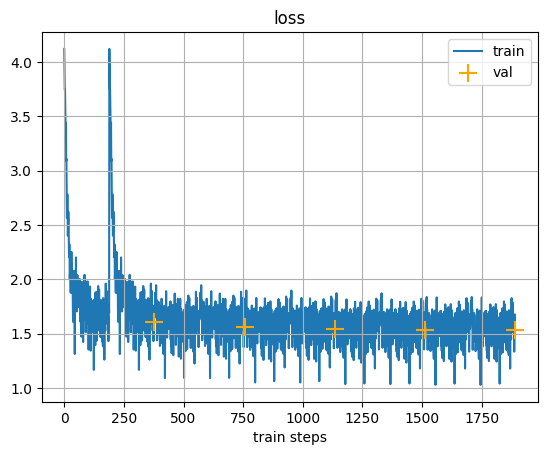

100%|██████████| 5/5 [00:21<00:00,  4.21s/it]


In [ ]:
import tqdm

model = NameTransformer(len(tokens), 64, 64, n_layers=2, n_head=2, dropout=0.1)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, opt, 5)

# Generate using argmax

Let's generate some  names, starting with particular prefix

In [ ]:
def pick_by_argmax(logits):
    return torch.max(logits, dim=-1)[1]

def ids2string(ids):
    return "".join(id2tok[_] for _ in ids)


def gen_continuation(model, prefix="_"):
    model.eval()

    if prefix[0] != '_':
      prefix = '_' + prefix

    outs = []

    nums = to_matrix([prefix])

    data = torch.tensor(nums)
    output = model(data)[0, -1].reshape(-1)
    out = pick_by_argmax(output)
    outs.append(out.item())

    #We generate while ???
    while out != tok2id['#'] and len(outs) < 20:#Your code here:

      nums = np.append(nums, out.numpy().reshape((1,1)), axis=1)

      data = torch.tensor(nums)
      output = model(data)[0,-1].reshape(-1)
      out = pick_by_argmax(output)
      outs.append(out.item())
    print(prefix + '|'+ ids2string(outs))

gen_continuation(model, "_Ku")

_Ku|rin#


In [ ]:
gen_continuation(model, "_Al")

_Al|llllllllllllllllllll


In [ ]:
gen_continuation(model)

_|Marin#


In [ ]:
gen_continuation(model)

_|Marin#


In [ ]:
gen_continuation(model, "_")

_|Marin#


In [ ]:
gen_continuation(model, "_M")

_M|arin#


In [ ]:
gen_continuation(model, "_Ma")

_Ma|rin#


# Generation with sampling

Regular softmax
$$p_i = \frac{\exp (x_i)}{\sum \exp (x_j)}$$
Adding temperature $T$:
$$p_i = \frac{\exp (x_i / T)}{\sum \exp (x_j / T)}$$

It may help to transition from the choosing the most probable ($T << 1$) to the almost uniform distribution ($T >> 1$)


In [ ]:
def batch2string(ids, prefix):
    # modification to work with batches
    gen_texts = ["".join(id2tok[_] for _ in ids_item) for ids_item in ids]
    return [prefix + gen_texts[i] for i in range(len(prefix))]


def pick_by_distribution(logits):
    # logits to probability
    # generate batch of examples
    soft = F.softmax(logits, dim=-1)
    return np.random.choice(list(range(soft.size()[0])), p=soft.numpy())


def gen_continuation_temp(model, prefix="_", temperature=1.0, n=10):
    model.eval()
    with torch.no_grad():

      if prefix[0] != '_':
          prefix = '_' + prefix

      nums_list = to_matrix([prefix] * n)


      out_list = []
      for i in range(n):
        outs = []
        nums = [nums_list[i]]



        data = torch.tensor(nums)
        output = model(data)[0,-1].reshape(-1)
        out = pick_by_distribution(output / temperature)
        outs.append(out)



        #We generate while ???
        while out != tok2id['#'] and len(nums[0]) < 20: #Your code here:


            nums = np.append(nums, np.array(out).reshape((1,1)), axis=1)

            data = torch.tensor(nums)
            output = model(data)[0,-1].reshape(-1)
            out = pick_by_distribution(output / temperature)
            outs.append(out)

        out_list.append(outs)



    print(batch2string(out_list, prefix + '|'))

In [ ]:
gen_continuation_temp(model, prefix="_Ku", temperature=0.5, n=10)

['_Ku|st#', '_Ku|arielenane#', '_Ku|rie#', '_Ku|s#']


In [ ]:
gen_continuation_temp(model, prefix="_Ku", temperature=1.5, n=10)

['_Ku|buicnonic#', '_Ku|rmtyie#', '_Ku|ingdrepvevelckithe', '_Ku|neerozgelkmappodrl']


In [ ]:
gen_continuation_temp(model, prefix="_Ku", temperature=50, n=10)

['_Ku|yEHAizwAddwA#', '_Ku|KeEd#', '_Ku|Sz-OHwsLZ_#', '_Ku|sAeUMZxtymuyDHhWLj']
